<a href="https://colab.research.google.com/github/Amaljayaranga/Autoencoders/blob/master/NvidiaGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

torch.Size([1, 3, 1024, 1024])
[[[ 0.21184894  0.20294556  0.20350733]
  [ 0.20321906  0.20338091  0.20332867]
  [ 0.20320848  0.20320189  0.20317945]
  ...
  [ 0.23099533  0.23099098  0.2309798 ]
  [ 0.23095223  0.23099083  0.23084071]
  [ 0.23132166  0.23481604  0.24651265]]

 [[ 0.21384671  0.23335677  0.23166817]
  [ 0.23097762  0.23067984  0.23064357]
  [ 0.23062661  0.23066011  0.23067105]
  ...
  [ 0.23029274  0.23028797  0.23027763]
  [ 0.23028588  0.23029798  0.23013201]
  [ 0.2305375   0.23328951  0.24537647]]

 [[ 0.2127808   0.23291495  0.23149738]
  [ 0.23070869  0.23030296  0.23031062]
  [ 0.23033059  0.23035115  0.23035887]
  ...
  [ 0.230326    0.23032779  0.23031473]
  [ 0.23032299  0.2303178   0.23011184]
  [ 0.23055151  0.23344952  0.24546796]]

 ...

 [[-0.08627176 -0.11476299 -0.11411984]
  [-0.11397111 -0.11408366 -0.11400025]
  [-0.11401201 -0.11404458 -0.11403187]
  ...
  [-0.11401748 -0.1140267  -0.11400975]
  [-0.11405409 -0.11399643 -0.11393639]
  [-0.1142316

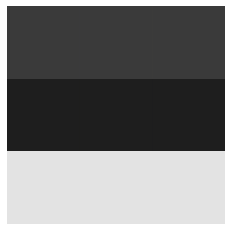

In [2]:
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch
from torchvision.datasets import MNIST
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from argparse import ArgumentParser
import seaborn as sns;sns.set()
from argparse import ArgumentParser

Z_SIZE = 1024
IN_Channels = int(Z_SIZE/16)


parser = ArgumentParser(description='Simase Network')
parser.add_argument('--learning_batch_size', type=int, default=64)
parser.add_argument('--fc_in_features', type=int, default=512)
parser.add_argument('--fc_out_features', type=int, default=64)
parser.add_argument('--constractive_loss_margin', type=float, default=1.0)
parser.add_argument('--learning_rate', type=float, default=1e-3)
parser.add_argument('--num_epochs', type=int, default=100)
parser.add_argument('--weight_decay', type=float, default=1e-5)
parser.add_argument('--validation_split', type=float, default=0.2)
parser.add_argument('--mode', type=str, default='train')
parser.add_argument('--device', type=str, default='cuda')
args, unknown = parser.parse_known_args()


class PixelNorm(nn.Module):
    def __init__(self, epsilon=1e-8):
        super(PixelNorm, self).__init__()
        self.epsilon = epsilon

    def forward(self, x):
        tmp = torch.mul(x, x)
        tmp = torch.rsqrt(torch.mean(tmp, dim=1, keepdim=True) + self.epsilon)
        return x * tmp

class Reshape(nn.Module):
    def __init__(self):
        super(Reshape, self).__init__()

    def forward(self, x):
        x = x.view(-1,IN_Channels,4,4)
        return x

class ConvBlock(nn.Module):

    def __init__(self,in_channel, out_channel):
        super(ConvBlock,self).__init__()

        self.conv = nn.Sequential(
                                    nn.Upsample(scale_factor=2, mode='nearest'),
                                    nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=3, stride=1, padding=1),
                                    nn.LeakyReLU(),
                                    PixelNorm(),
                                    nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=3, stride=1, padding=1),
                                    nn.LeakyReLU(),
                                    PixelNorm(),
                                    )
    def forward(self, x):
         x = self.conv(x)
         return x


class Encoder(nn.Module):

    def __init__(self):
        super(Encoder,self).__init__()

        encoder_pretrained = torchvision.models.densenet121(pretrained=True)
        features_pretrained = next(iter(encoder_pretrained.children()))

        self.encoder = torch.nn.Sequential()
        self.z_num_features = 0
        for name, module in features_pretrained.named_children():
            if name == 'norm5':
                self.z_num_features = module.num_features
            self.encoder.add_module(name, module)
        self.encoder.add_module('avg_pool', torch.nn.AdaptiveAvgPool2d(output_size=1))
        #z size = 1024

    def forward(self, x):
        z = self.encoder(x)
        return z

class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()

        self.initial = nn.Sequential(PixelNorm(),
                                     nn.Linear(Z_SIZE, Z_SIZE),
                                     nn.LeakyReLU(),
                                     PixelNorm(),
                                     Reshape(),
                                     nn.Conv2d(in_channels=IN_Channels, out_channels=IN_Channels, kernel_size=3, stride=1, padding=1),
                                     nn.LeakyReLU(),
                                     PixelNorm()
                                     )

        self.middle = nn.Sequential(ConvBlock(IN_Channels,IN_Channels), #8
                                    ConvBlock(IN_Channels,IN_Channels), #16
                                    ConvBlock(IN_Channels,IN_Channels), #32
                                    ConvBlock(IN_Channels,IN_Channels), #64
                                    ConvBlock(IN_Channels,IN_Channels), #128
                                    ConvBlock(IN_Channels,IN_Channels), #256
                                    ConvBlock(IN_Channels,IN_Channels), #512
                                    ConvBlock(IN_Channels, IN_Channels)) #1024

        self.last = nn.Conv2d(in_channels=IN_Channels, out_channels=3, kernel_size=1)


    def forward(self, z):
        x = self.initial(z)
        x = self.middle(x)
        x = self.last(x)
        return x


class Full(nn.Module):

    def __init__(self):
        super(Full, self).__init__()

        self.encoder = Encoder()
        self.genarator = Generator()

    def forward(self, x):
        z = self.encoder(x)
        z = z.view(-1, Z_SIZE)
        out = self.genarator(z)
        return out


def draw(features):
    features1 = features.squeeze()
    to_pil = torchvision.transforms.ToPILImage()
    img = to_pil(features1)
    img.show()

def display_image(img):
  img1 = img.squeeze()
  img1 = img1.detach().numpy()
  img1 = np.reshape(img1, (1024, 1024,3))
  print(img1)
  img2 = (img1 * 255).astype(np.uint8)
  print(img2)
  plt.figure()
  plt.imshow(img2)
  #plt.imshow((img1 * 255).astype(np.uint8))
  plt.grid(False);  plt.axis('off'); plt.show()


# Datasets from folders
data = {
    'train':
    datasets.ImageFolder(root='./train/',
                         transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])),
    'valid':
    datasets.ImageFolder(root='./test/', 
                         transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])),
}

# Dataloader iterators, make sure to shuffle
dataloaders = {
    'train': DataLoader(data['train'], batch_size=1, shuffle=True),
    'valid': DataLoader(data['valid'], batch_size=1, shuffle=True)
}

DEVICE = args.device
if not torch.cuda.is_available():
    DEVICE = 'cpu'


model = Full()
model = model.to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)

train = False

if train:
    for epoch in range(args.num_epochs):
        for image, label in iter(dataloaders['train']):
            image = image.to(DEVICE)
            output = model(image)
            loss = criterion(output,image)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print('Epoch :', epoch+1, 'Loss:',loss.item())

    torch.save(model, './nn_autoencoder.pth')

if not train:
    model = torch.load('./nn_autoencoder.pth')
    model = model.to(DEVICE)
    model.eval()

    for image, label in iter(dataloaders['valid']):
        image = image.to(DEVICE)
        output = model(image)
        output = output.to('cpu')
        print(output.shape)
        display_image(output)
